In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image

# Importo librerias de Scikit Learn
Puntualmente nos interesa importar el modelo de Regresion Lineal, la medida de error cuadratico medio, y el divisor de datos entre train y test.

In [2]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from sklearn.model_selection import GridSearchCV

# Importo dataset de Airbnb 
Desde Airbnb obtenemos el siguiente dataset para entrenar nuestros modelos de regresion http://insideairbnb.com/get-the-data.html (dataset "listings.csv" de London). 

Objetivo: Vamos a querer predecir el precio dadas ciertas features.

In [3]:
pwd

'C:\\Users\\Kotz\\Documents\\Ciencia de datos\\Clases 2020\\clusterai_2020-master\\clases\\clase_05'

In [6]:
# importo el dataset de Airbnb London, lo guardamos en el dataframe "london".
london = pd.read_csv(r'C:\Users\Kotz\Documents\Ciencia de datos\Clases 2020\clusterai_2020-master\datasets\airbnb/clusterai_regresion_dataset_airbnb_london.csv', delimiter=',', parse_dates = True)

In [7]:
# observo la cantidad de renglones y columnas del dataset importado
np.shape(london)

(75213, 16)

In [8]:
# exploro las columnas que tiene el dataframe importado
london.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')

### Nuestro objetivo va a ser predecir el precio

In [9]:
#visualizo los primeros 3 renglones de mi dataset
london.head(3)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,9554,"Cozy, 3 minutes to Piccadilly Line",31655,Guy,NaN,Haringey,51.587767,-0.105666,Private room,35,1,131,2018-08-03,1.71,4,262
1,11076,The Sanctuary,40471,Rosa,NaN,Ealing,51.515645,-0.314508,Private room,70,2,2,2016-11-23,0.07,6,62
2,13913,Holiday London DB Room Let-on going,54730,Alina,NaN,Islington,51.568017,-0.111208,Private room,45,1,14,2018-06-17,0.14,2,364


In [11]:
# cuento cuantos NaNs tengo por columna
london.isnull().sum()

id                                    0
name                                 31
host_id                               0
host_name                            13
neighbourhood_group               75213
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       20353
reviews_per_month                 20357
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [12]:
# elimino las rows que tienen NaNs en la columna "reviews_per_month" , que otras opciones existen?
london = london.dropna(subset = ["reviews_per_month"])

In [13]:
# reviso como queda mi dataframe luego de eliminar los renglones con NaNs en review per month
london.shape

(54856, 16)

## Visualización rápida de las features de interes con Pairplot (Seaborn)

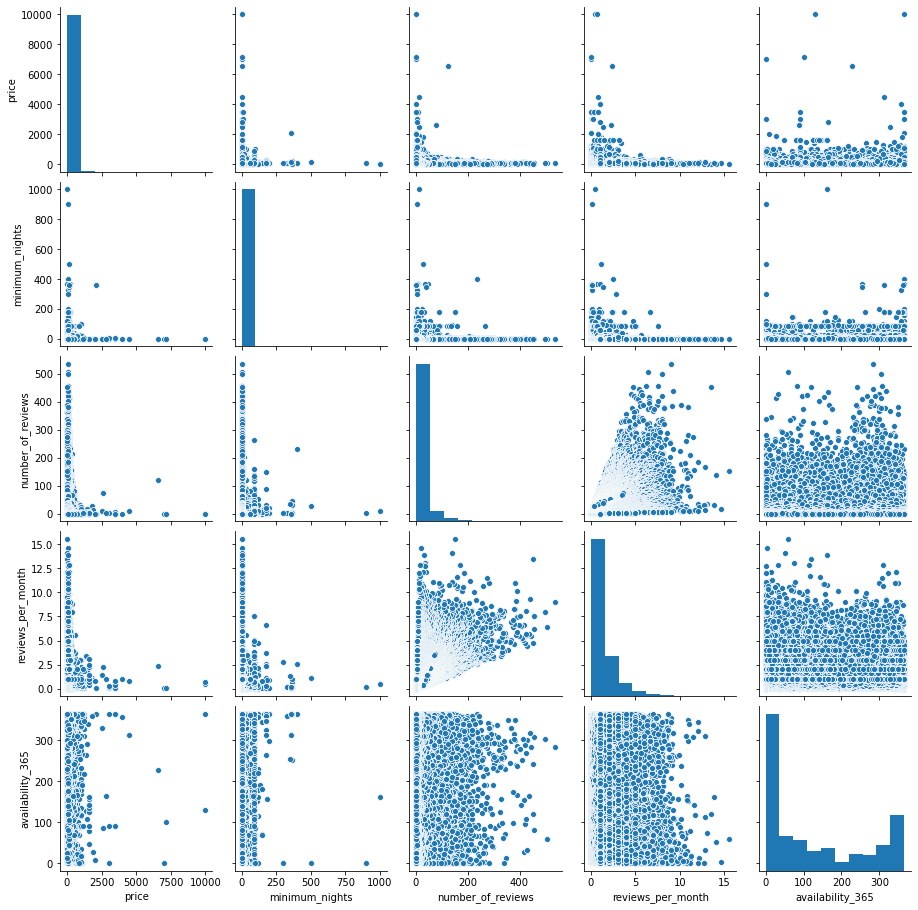

In [14]:
sns.pairplot(london[["price", "minimum_nights", "number_of_reviews", "reviews_per_month", "availability_365"]])
plt.show()

# Vemos con los gráfs que hay correlacion fuerte entre una y otra, nada que llame mucho la atencion.

## Elimino con .drop las columnas que no son de interes

No voy a utilizar la info de esas columnas para determinar el precio

In [15]:
london = london.drop(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group', 'last_review', 'latitude', 'longitude'], axis=1)
#Que features que eliminamos podrian llegar a ser utiles?

Link util -->
https://medium.com/@khadijamahanga/using-latitude-and-longitude-data-in-my-machine-learning-problem-541e2651e08c

In [16]:
london.head(3)

,neighbourhood,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Haringey,Private room,35,1,131,1.71,4,262
1,Ealing,Private room,70,2,2,0.07,6,62
2,Islington,Private room,45,1,14,0.14,2,364


## Reviso si los valores máximos de cada feature se condicen con el contexto

Con que objetivo queremos ver esta informacion?

In [18]:
# Veo los valores máximos
np.max(london)

neighbourhood                     Westminster
room_type                         Shared room
price                                   10000
minimum_nights                           1000
number_of_reviews                         536
reviews_per_month                       15.56
calculated_host_listings_count           1034
availability_365                          365
dtype: object

## Obtengo los percentiles 97 de price y Minimum nights para filtrar outliers de estas features

Voy a sacar esos valores altos que creo que me ensucian el dataset. 
El criterio que uso para eliminarlos es con percentiles

In [19]:
price_q97 = london.price.quantile(0.975)
print("el cuantil 0.97 de la feature 'price' es = " + str(price_q97))

el cuantil 0.97 de la feature 'price' es = 300.0


In [20]:
min_nights_q97 = london.minimum_nights.quantile(0.975)
print("el cuantil 0.97 de la feature 'minimum_nights' es = " + str(min_nights_q97))

el cuantil 0.97 de la feature 'minimum_nights' es = 14.0


## Outlier Filtering: Filtro mi dataset por los percentiles calculados en el paso anterior bajo las features correspondientes



In [21]:
# Acá filtro y conservo los valores que cumplen las dos condiciones al mismo tiempo. Acoto mis valores.
london_filt = london.loc[(london.price < price_q97) & (london.minimum_nights < min_nights_q97)]

In [22]:
london_filt.shape

(51827, 8)

In [23]:
london_filt.head(3)

,neighbourhood,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Haringey,Private room,35,1,131,1.71,4,262
1,Ealing,Private room,70,2,2,0.07,6,62
2,Islington,Private room,45,1,14,0.14,2,364


## Feature Engineering: Genero variables dummies para las features categoricas (Neighbourhood y Room Type)

In [24]:
# dummies para la feature "neighbourhood" - agrega 1 columna para cada valor de Neighbourhood posible, completando con 0 y 1.
neighs_dummie = pd.get_dummies(london_filt.neighbourhood)
neighs_dummie.head(3)

,Barking and Dagenham,Barnet,Bexley,Brent,Bromley,Camden,City of London,Croydon,Ealing,Enfield,...,Merton,Newham,Redbridge,Richmond upon Thames,Southwark,Sutton,Tower Hamlets,Waltham Forest,Wandsworth,Westminster
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
neighs_dummie.shape

(51827, 33)

In [26]:
# Ejemplo de dummies para la feature "room_type"
room_dummie = pd.get_dummies(london_filt.room_type)
room_dummie.head(3)

,Entire home/apt,Private room,Shared room
0,0,1,0
1,0,1,0
2,0,1,0


In [27]:
room_dummie.shape

(51827, 3)

## Agrego las nuevas variables dummies creadas al dataframe de trabajo 'london_filt'

In [28]:
london_filt = london_filt.join([neighs_dummie, room_dummie])

In [29]:
london_filt.head(3)

,neighbourhood,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,Barking and Dagenham,Barnet,...,Richmond upon Thames,Southwark,Sutton,Tower Hamlets,Waltham Forest,Wandsworth,Westminster,Entire home/apt,Private room,Shared room
0,Haringey,Private room,35,1,131,1.71,4,262,0,0,...,0,0,0,0,0,0,0,0,1,0
1,Ealing,Private room,70,2,2,0.07,6,62,0,0,...,0,0,0,0,0,0,0,0,1,0
2,Islington,Private room,45,1,14,0.14,2,364,0,0,...,0,0,0,0,0,0,0,0,1,0


In [30]:
print("La cantidad de features nuevas agregadas a dataframe son = " + str(np.shape(neighs_dummie)[1]+np.shape(room_dummie)[1]))

La cantidad de features nuevas agregadas a dataframe son = 36


## Creamos nuestra variable dependiente (label - etiqueta) y

Y sera el precio (variable a predecir)

In [31]:
y = np.array(london_filt[["price"]])

## Creamos nuestra variable Independiente X quitando las features que no deseamos

In [32]:
x = london_filt.drop(['price', 'neighbourhood','room_type'], axis=1)

In [33]:
np.shape(x)

(51827, 41)

## Divido el dataset entre Train y Test

In [34]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.90, random_state=42)

In [35]:
xtrain.head()

,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,Barking and Dagenham,Barnet,Bexley,Brent,Bromley,...,Richmond upon Thames,Southwark,Sutton,Tower Hamlets,Waltham Forest,Wandsworth,Westminster,Entire home/apt,Private room,Shared room
4109,3,10,0.61,1,321,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
8703,1,2,0.05,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
62456,4,1,0.94,1,137,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
7200,2,2,0.18,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
44756,1,3,0.25,1,220,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0


In [36]:
xtrain.shape

(5182, 41)

In [37]:
# Step 4: auto scaling train- set (mean = 0, std = 1).
# StandardScaler para optimizar resultados

# RECORDAR escalar los sets de Train y Test POR SEPARADO >> sino, me va a calcular la media y varianza de todo.
# Yo no puedo asumir que ambos sets tienen la misma media implicita!
scaler = preprocessing.StandardScaler().fit(xtrain)
scaler

StandardScaler()

In [38]:
# auto scalo mis muestras de train utilizando el scaler fiteado con el xtrain
xtrain_scal = scaler.transform(xtrain)  

In [39]:
# auto scalo mis muestras de test utilizando el scaler fiteado con el xtrain
xtest_scal = scaler.transform(xtest)  

# Creo un modelo de Regresión Lineal

In [40]:
# 1) creo un modelo generico de regresion lineal. El modelo más simple, para que nos sirva DE BASE. 
# Decimos "De Base" porque será el resultado que corre mas rapido, con el error que sea que tenga.
lr = LinearRegression()

In [41]:
# 2) Ajusto el modelo de regresion lineal utilizando el set de train, tanto las features X como las samples Y
lr.fit(xtrain_scal, ytrain)

LinearRegression()

In [42]:
# 3) Obtengo las predicciones que realiza mi modelo con las muestras de test, sin mostrarle las labels (Ytest)
# las predicciones las guardo en el vector "ypred"
ypred = lr.predict(xtest_scal)

In [43]:
np.shape(ypred)

(46645, 1)

In [44]:
# calculo el error de mi modelo con las muestras de train = error de train
np.sqrt(mean_squared_error(ytest, ypred))

39.299588589114684

In [45]:
mean_squared_error(ytest, ypred)

1544.457663273673

In [46]:
from sklearn.metrics import mean_absolute_error

In [47]:
mean_absolute_error(ytest, ypred)

28.085250295268555

![Inner join](https://i.imgflip.com/1vgxmu.jpg)

## Armar tres modelos de regresion usando:

    -KNN Regression
    Utilizar un GridSearchCV: como base podes utilizar los siguientes parametros
    parameters_k = np.arange(20,31,5)
    parameters_knn = [{'n_neighbors': parameters_k}]
    
    https://scikit-learn.org/stable/auto_examples/neighbors/plot_regression.html?highlight=knn
    
    -SVR
    Utilizar un GridSearchCV: como base podes utilizar los siguientes parametros:
    ​parameters_svr_rbf = [{'kernel':['rbf'] , 'C': [1,100],'gamma': [0.1,0.5] }]
    
    -Random Forest regressor
    Utilizar un GridSearchCV: como base podes utilizar los siguientes parametros:
    'n_estimators': [100, 200, 300, 1000]
    
    https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor.set_params

### Comparar el R2, RMSE, MAE

Competencia

Mayor R2 = { }

Menor RMSE = { }

Menor MAE = { }

In [48]:
# Creamos un dataframe para guardar los resultados de cada estimador. Luego con eso haremos comparaciones

results_df = pd.DataFrame(columns=['Model','R2','MSE','MAE'])

### SVR

In [53]:
#Definimos el estimador. Aca le definimos una cantidad limite de iteraciones con max_iter.
est = SVR(max_iter=25000)

# Lista del parametro lambda (parametro 'alpha'). 
parameters_svr_rbf = {'kernel':['rbf'] , 
                      'C': [1,100],
                      'gamma': [0.1,0.5] }

n_folds=5

# Definimos el objeto GS con los parametros previamente definidos
gs = GridSearchCV(est, param_grid=parameters_svr_rbf,refit=True,
                  cv=n_folds, scoring="neg_mean_squared_error",
                  verbose=3, n_jobs=3)


In [55]:
#Entrenamos
gs.fit(xtrain_scal, ytrain)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  20 out of  20 | elapsed:   27.0s finished
C:\Users\Kotz\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


GridSearchCV(cv=5, estimator=SVR(max_iter=25000), n_jobs=3,
             param_grid={'C': [1, 100], 'gamma': [0.1, 0.5], 'kernel': ['rbf']},
             scoring='neg_mean_squared_error', verbose=3)

In [56]:
# Mostramos el mejor estimador, sus hyperparametros seleccionados y su resultado
print(gs.best_estimator_, "\n")
print(gs.best_params_, "\n")
print(gs.best_score_, "\n")

SVR(C=100, gamma=0.1, max_iter=25000) 

{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'} 

-1680.886555843345 



In [57]:
# Prediccion + Metricas
svr_prediction = gs.best_estimator_.predict(xtest_scal)
svr_r2 = r2_score(y_true=ytest, y_pred=svr_prediction)
svr_mse = mean_squared_error(y_true=ytest, y_pred=svr_prediction)
svr_mae = mean_absolute_error(y_true=ytest, y_pred=svr_prediction)

R2 score: 0.479678
MAE: 27.193622
MSE: 1629.680183


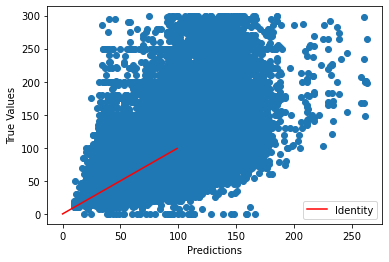

In [58]:
# Ploteamos Predictions vs True values
plt.scatter(svr_prediction, ytest)
plt.plot(np.arange(0,100),np.arange(0,100), 'r', label='Identity')
plt.xlabel('Predictions')
plt.ylabel('True Values')
plt.legend()
print(f'R2 score: {svr_r2:.6f}')
print(f'MAE: {svr_mae:.6f}')
print(f'MSE: {svr_mse:.6f}')

In [59]:
results_df = results_df.append({'Model':'SVR',
                                'R2':svr_r2,
                                'MSE':svr_mse,
                                'MAE':svr_mae},ignore_index=True)

In [60]:
results_df

,R2,MSE,MAE,Model
0,0.479678,1629.680183,27.193622,SVR


### Random Forest regressor

In [74]:
#Importamos el modelo
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

In [ ]:
#Definimos el estimador.
est = 

# Lista del parametro lambda (parametro 'alpha'). 
parameters_rfg = {'n_estimators': [100, 200, 300, 1000]}

n_folds=5

# Definimos nuevamente el objeto GS con los parametros previamente definidos
gs = GridSearchCV(est, param_grid=parameters_rfg,refit=True,
                  cv=n_folds, scoring="neg_mean_squared_error",
                  verbose=3, n_jobs=3)


### KNN

In [78]:
#Definimos el estimador y los parámetros
knn = KNeighborsRegressor()
parameters_k = np.arange(20,31,5)
parameters_knn = [{'n_neighbors': parameters_k}]

n_folds=5

# Definimos nuevamente el objeto GS con los parametros previamente definidos
gs = GridSearchCV(knn, param_grid=parameters_knn,refit=True,
                  cv=n_folds, scoring="neg_mean_squared_error",
                  verbose=3, n_jobs=3)

In [79]:
#Entrenamos
gs.fit(xtrain_scal, ytrain)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  15 out of  15 | elapsed:    4.0s finished


GridSearchCV(cv=5, estimator=KNeighborsRegressor(), n_jobs=3,
             param_grid=[{'n_neighbors': array([20, 25, 30])}],
             scoring='neg_mean_squared_error', verbose=3)

In [80]:
# Mostramos el mejor estimador, sus hyperparametros seleccionados y su resultado
print(gs.best_estimator_, "\n")
print(gs.best_params_, "\n")
print(gs.best_score_, "\n")

KNeighborsRegressor(n_neighbors=20) 

{'n_neighbors': 20} 

-1633.0440172967944 



In [81]:
# Prediccion + Metricas
knn_prediction = gs.best_estimator_.predict(xtest_scal)
knn_r2 = r2_score(y_true=ytest, y_pred=knn_prediction)
knn_mse = mean_squared_error(y_true=ytest, y_pred=knn_prediction)
knn_mae = mean_absolute_error(y_true=ytest, y_pred=knn_prediction)

R2 score: 0.493432
MAE: 28.067338
MSE: 1586.600613


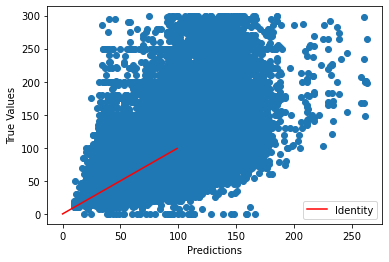

In [83]:
# Ploteamos Predictions vs True values

plt.scatter(svr_prediction, ytest)
plt.plot(np.arange(0,100),np.arange(0,100), 'r', label='Identity')
plt.xlabel('Predictions')
plt.ylabel('True Values')
plt.legend()
print(f'R2 score: {knn_r2:.6f}')
print(f'MAE: {knn_mae:.6f}')
print(f'MSE: {knn_mse:.6f}')

In [84]:
# Guardamos los resultados
results_df = results_df.append({'Model':'KNN',
                                'R2':knn_r2,
                                'MSE':knn_mse,
                                'MAE':knn_mae},ignore_index=True)

In [85]:
results_df

,R2,MSE,MAE,Model
0,0.479678,1629.680183,27.193622,SVR
1,0.493432,1586.600613,28.067338,KNN


### Random Forest regressor

In [86]:
#Importamos el modelo
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

In [87]:
#Definimos el estimador.
est = RandomForestRegressor()

# Lista del parametro lambda (parametro 'alpha'). 
parameters_rfg = {'n_estimators': [100, 200, 300, 1000]}

n_folds=5

# Definimos nuevamente el objeto GS con los parametros previamente definidos
gs = GridSearchCV(est, param_grid=parameters_rfg,refit=True,
                  cv=n_folds, scoring="neg_mean_squared_error",
                  verbose=3, n_jobs=3)

In [88]:
#Entrenamos
gs.fit(xtrain_scal, ytrain)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  20 out of  20 | elapsed:  1.5min finished
C:\Users\Kotz\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:765: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=3,
             param_grid={'n_estimators': [100, 200, 300, 1000]},
             scoring='neg_mean_squared_error', verbose=3)

In [89]:
# Mostramos el mejor estimador, sus hyperparametros seleccionados y su resultado
print(gs.best_estimator_, "\n")
print(gs.best_params_, "\n")
print(gs.best_score_, "\n")

RandomForestRegressor(n_estimators=1000) 

{'n_estimators': 1000} 

-1598.9387601835056 



In [90]:
# Prediccion + Metricas
rfr_prediction = gs.best_estimator_.predict(xtest_scal)
rfr_r2 = r2_score(y_true=ytest, y_pred=rfr_prediction)
rfr_mse = mean_squared_error(y_true=ytest, y_pred=rfr_prediction)
rfr_mae = mean_absolute_error(y_true=ytest, y_pred=rfr_prediction)

R2 score: 0.489301
MAE: 28.116899
MSE: 1599.539621


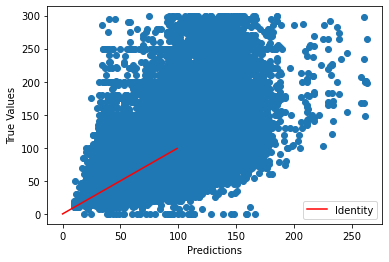

In [91]:
# Ploteamos Predictions vs True values

plt.scatter(svr_prediction, ytest)
plt.plot(np.arange(0,100),np.arange(0,100), 'r', label='Identity')
plt.xlabel('Predictions')
plt.ylabel('True Values')
plt.legend()
print(f'R2 score: {rfr_r2:.6f}')
print(f'MAE: {rfr_mae:.6f}')
print(f'MSE: {rfr_mse:.6f}')

In [92]:
# Guardamos los resultados
results_df = results_df.append({'Model':'RFR',
                                'R2':rfr_r2,
                                'MSE':rfr_mse,
                                'MAE':rfr_mae},ignore_index=True)

In [93]:
# Mostramos los resultados para comparar los tres modelos
results_df

,R2,MSE,MAE,Model
0,0.479678,1629.680183,27.193622,SVR
1,0.493432,1586.600613,28.067338,KNN
2,0.489301,1599.539621,28.116899,RFR
